# ECG Denoising

> We believe we can produce a more robust ECG classifier by learning representations of noisy ECG signals

In [1]:
from pathlib import Path

import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.utils import resample

import os
os.environ["KERAS_BACKEND"] = "torch"

from ecg_classification.preprocessing import SyntheticNoise, preprocess_ecg_signals
from ecg_classification.models import CDAE
from ecg_classification.visualize import plot_ecg, plot_multiple_ecg
from ecg_classification.training import make_ecg_data_train_test_split, print_split_summary, randomly_oversample_minority_class, DataSplit

In [2]:
train, test = make_ecg_data_train_test_split(np.load(Path("../data/icentia11k/data.npz")), test_size=0.3, random_state=42)
print_split_summary(train)
print()
print_split_summary(test)

train split (31440, 800)
3525/31440 (0.1121) abnormal beats
34/31440 (0.0011) abnormal rhythms

test split (15720, 800)
46/15720 (0.0029) abnormal beats
277/15720 (0.0176) abnormal rhythms


In [3]:
# Rebalance absolute number of classes
train = randomly_oversample_minority_class(train, 0.1, random_state=42)
print_split_summary(train)

train split (34602, 800)
3525/34602 (0.1019) abnormal beats
3196/34602 (0.0924) abnormal rhythms


In [4]:
# Then downsample normal, to reduce training costs for now
train = DataSplit("train", *resample(train.X, train.y_rhythm, train.y_beat, n_samples=10_000, stratify=train.y_rhythm))
print_split_summary(train)

train split (10000, 800)
959/10000 (0.0959) abnormal beats
924/10000 (0.0924) abnormal rhythms


In [5]:
# Apply simple signal preprocessing - smoothing, detrending, normalizing
train.X = preprocess_ecg_signals(train.X)
train.X.shape

(10000, 800)

## Types of Noise

Powerline Interfance

Baseline Wander

Muscle artifacts

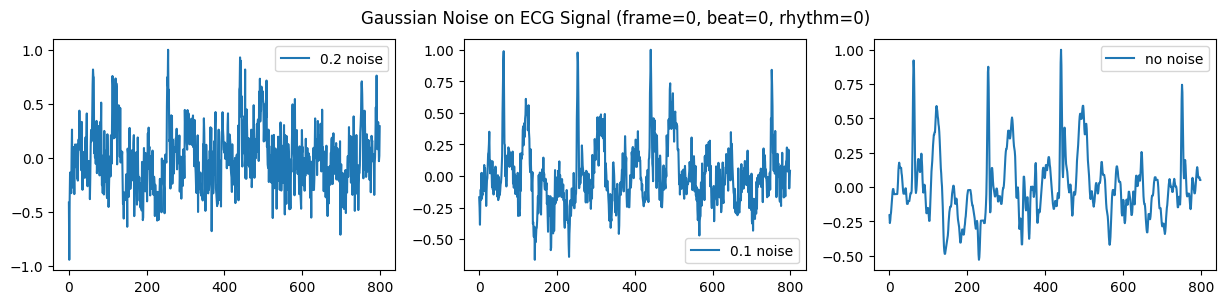

In [9]:
# Example gaussian noise applied to training example 0
syn_noise = SyntheticNoise(random_state=42)

frame = 0
fig, ax = plot_multiple_ecg([
    syn_noise.gaussian_noise(train.X[frame].reshape(1, -1), stddev=0.2)[0],
    syn_noise.gaussian_noise(train.X[frame].reshape(1, -1), stddev=0.1)[0],
    train.X[0]
], labels=["0.2 noise", "0.1 noise", "no noise"], layout="hstack")
fig.suptitle(f"Gaussian Noise on ECG Signal ({frame=}, beat={train.y_beat[frame]}, rhythm={train.y_rhythm[frame]})")
plt.legend();

## CDAE

Convolutional Denoising Autoencoder (CDAE) is models noisy ECG signals by learning to recover a clean ECG signal from a noisified version.

The original paper (Soto & Ashley 2020) that we base our multi-task model architecture on demonstrated good classification performance when the transfered the learned representation of ECG from CDAE to their main model.

In [ ]:
cdae = CDAE(input_size=800, models_path=Path("../models"))
cdae.model.summary()

In [ ]:
from keras import callbacks

In [ ]:
# # Initial learning rate
# initial_lr = 0.01

def lr_schedule(epoch: int, lr: float) -> float:
    if epoch % 25 == 0 and epoch > 0:
        # Make sure the learning rate does not become negative
        return max(lr - 0.001, 0.0001)
    return lr

lr_reduction = callbacks.LearningRateScheduler(lr_schedule, verbose=1)

Cross-Validation

In [ ]:
def prep_noisy_dataset(X: npt.NDArray, noise_levels: npt.NDArray, samples_per_level: int) -> npt.NDArray:
    """Creates a dataset of noisy and original signals for use in training a CDAE
    
    Args:
        X: original raw signals, each row is an ECG signal
        noise_levels: levels of noise to apply
        samples_per_level: number of examples per noise level to create
    """
    noise_levels = np.repeat(noise_levels, samples_per_level, axis=0)
    print(noise_levels, len(noise_levels))

    X_noisy = np.concatenate([syn_noise.gaussian_noise(X, lvl) for lvl in noise_levels], axis=0)

    return X_noisy, X

a, b = prep_noisy_dataset(train.X[1:10, 1:5], np.array([0.01, 0.05, 0.1, 0.2]), samples_per_level=2)
a.shape, b.shape

In [ ]:
# Train Autoencoder
history = cdae.fit(
    # The input to the CDAE was the simulated signal dataset
    # with a Gaussian noise factor of 0.001, 0.5, 0.25, 0.75,
    # 1, 2, and 5 added to corrupt the simulated signals.
    x=simulated_noisy_train_data,

    # The uncorrupted simulated signals are then used as the
    # target for reconstruction.
    y=np.tile(train_data, (len(noise_levels), 1, 1)),
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(simulated_noisy_validate_data, np.tile(validate_data, (len(noise_levels), 1, 1))),
    callbacks=[lr_reduction]
)

print(history.history)